In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from datetime import datetime
from amplpy import AMPL

AMPL_FOLDER = r'C:\Users\crhac\CATSSP\AMPL\data'
AMPL_MOD = r'C:\Users\crhac\CATSSP\AMPL\modelo.mod'

print(" Configuración cargada exitosamente")
print(f" Carpeta de datos: {AMPL_FOLDER}")
print(f" Modelo AMPL: {AMPL_MOD}")

 Configuración cargada exitosamente
 Carpeta de datos: C:\Users\crhac\CATSSP\AMPL\data
 Modelo AMPL: C:\Users\crhac\CATSSP\AMPL\modelo.mod


In [2]:
def diagnosticar_infactibilidad(dat_path):
    """Función para diagnosticar problemas de infactibilidad"""
    ampl = AMPL()
    ampl.read(AMPL_MOD)
    ampl.read_data(dat_path)
    
    nodes = list(ampl.get_set('NODES'))
    prohibited = list(ampl.get_set('PROHIBITED'))
    C = ampl.get_parameter('C')
    
    print(f"Nodos: {nodes}")
    print(f"Número de nodos: {len(nodes)}")
    print(f"Arcos prohibidos: {prohibited}")
    
    try:
        start_node = ampl.get_parameter('start_node').value()
        end_node = ampl.get_parameter('end_node').value()
        print(f"Nodo inicial: {start_node}")
        print(f"Nodo final: {end_node}")
        print("Problema tipo CATSSP-BC detectado")
    except:
        print("Sin restricciones de inicio/fin - problema TSP clásico")
        start_node = None
        end_node = None
    
    diagonal_minus_ones = []
    for i in nodes:
        try:
            if C[i, i] == -1:
                diagonal_minus_ones.append(i)
        except:
            pass
    
    if diagonal_minus_ones:
        print(f" Nodos con C[i,i] = -1: {diagonal_minus_ones}")
        print("   Los costos en la diagonal deberían ser infinitos o muy altos.")
    else:
        print("Matriz de costos correcta")
    
    return start_node, end_node

def corregir_matriz_costos(dat_path, nuevo_archivo=None):
    """Corrige la matriz de costos reemplazando -1 con valores muy altos"""
    with open(dat_path, 'r') as f:
        contenido = f.read()
    
    import re
    numeros = re.findall(r'\b\d+\b', contenido)
    if numeros:
        max_valor = max(int(n) for n in numeros)
        valor_infinito = max_valor + 1000
    else:
        valor_infinito = 9999
    
    print(f"🔧 Reemplazando valores -1 con {valor_infinito}")
    
    contenido_corregido = contenido.replace('-1', str(valor_infinito))
    
    if nuevo_archivo is None:
        base_name = dat_path.replace('.dat', '_corregido.dat')
        nuevo_archivo = base_name
    
    with open(nuevo_archivo, 'w') as f:
        f.write(contenido_corregido)
    
    print(f" Archivo corregido guardado como: {os.path.basename(nuevo_archivo)}")
    return nuevo_archivo

In [3]:
def ejecutar_instancia_con_solver(dat_path, solver='gurobi', time_limit=120):
    """Ejecuta una instancia con un solver específico"""
    ampl = AMPL()
    ampl.read(AMPL_MOD)
    ampl.read_data(dat_path)
    
    ampl.set_option('solver', solver)
    
    if solver.lower() == 'gurobi':
        ampl.set_option('gurobi_options', f'timelimit={time_limit}')
    elif solver.lower() == 'highs':
        ampl.set_option('highs_options', f'time_limit={time_limit}')
    elif solver.lower() == 'cplex':
        ampl.set_option('cplex_options', f'timelimit={time_limit}')
    
    inicio = time.time()
    try:
        ampl.solve()
        fin = time.time()
        
        solve_result = ampl.get_value("solve_result")
        
        if solve_result in ["infeasible", "INFEASIBLE"]:
            return {
                'solver': solver,
                'estado': 'infeasible',
                'costo': None,
                'tiempo': fin - inicio,
                'arcos': [],
                'num_arcos': 0,
                'error': None
            }
        
        x = ampl.get_variable('x')
        arcos = [(i, j) for i, j, val in x.get_values().to_list() if val > 0.5]
        
        obj = ampl.get_objective('TotalCost')
        costo = obj.value()
        
        return {
            'solver': solver,
            'estado': solve_result,
            'costo': costo,
            'tiempo': fin - inicio,
            'arcos': arcos,
            'num_arcos': len(arcos),
            'error': None
        }
        
    except Exception as e:
        fin = time.time()
        return {
            'solver': solver,
            'estado': 'error',
            'costo': None,
            'tiempo': fin - inicio,
            'arcos': [],
            'num_arcos': 0,
            'error': str(e)
        }

In [4]:
def comparar_solvers_completo(carpeta_data=None, solvers=['gurobi', 'highs', 'cplex'], 
                             time_limit=120, corregir_datos=True, 
                             incluir_graficos=False, guardar_resultados=True):
    """
    Función completa para comparar múltiples solvers en todos los archivos .dat
    """
    
    if carpeta_data is None:
        carpeta_data = AMPL_FOLDER
    
    patron = os.path.join(carpeta_data, "*.dat")
    archivos_dat = glob.glob(patron)
    
    if not archivos_dat:
        print(f" No se encontraron archivos .dat en {carpeta_data}")
        return None
    
    print(f" Encontrados {len(archivos_dat)} archivos .dat")
    print(f" Solvers a comparar: {solvers}")
    print(f" Límite de tiempo: {time_limit} segundos")
    print("=" * 80)
    
    resultados = []
    archivos_corregidos = {}
    
    for archivo_path in archivos_dat:
        archivo_nombre = os.path.basename(archivo_path)
        print(f"\n Procesando: {archivo_nombre}")
        print("-" * 60)
        
        try:
            print(" Diagnóstico inicial...")
            start_node, end_node = diagnosticar_infactibilidad(archivo_path)
            
            archivo_a_usar = archivo_path
            if corregir_datos:
                with open(archivo_path, 'r') as f:
                    contenido = f.read()
                
                if '-1' in contenido:
                    print(" Aplicando corrección de valores -1...")
                    archivo_corregido = corregir_matriz_costos(archivo_path)
                    archivos_corregidos[archivo_nombre] = archivo_corregido
                    archivo_a_usar = archivo_corregido
                else:
                    print(" Archivo no necesita corrección")
            
        except Exception as e:
            print(f" Error en diagnóstico: {e}")
            continue
        
        for solver in solvers:
            print(f"\n🔧 Probando solver: {solver.upper()}")
            
            resultado = ejecutar_instancia_con_solver(archivo_a_usar, solver, time_limit)
            
            resultado['archivo'] = archivo_nombre
            resultado['archivo_corregido'] = archivo_nombre in archivos_corregidos
            resultado['start_node'] = start_node
            resultado['end_node'] = end_node
            resultado['timestamp'] = datetime.now()
            
            resultados.append(resultado)
            
            if resultado['estado'] in ['solved', 'optimal']:
                print(f"   {solver}: Costo = {resultado['costo']:.2f}, Tiempo = {resultado['tiempo']:.4f}s")
            elif resultado['estado'] == 'infeasible':
                print(f"   {solver}: INFEASIBLE")
            else:
                print(f"   {solver}: {resultado['estado']}")
                if resultado['error']:
                    print(f"      Error: {resultado['error']}")
    
    df_resultados = pd.DataFrame(resultados)
    
    if guardar_resultados and not df_resultados.empty:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        archivo_csv = os.path.join(carpeta_data, f"comparacion_solvers_{timestamp}.csv")
        df_resultados.to_csv(archivo_csv, index=False)
        print(f"\n Resultados guardados en: {os.path.basename(archivo_csv)}")
    
    mostrar_resumen_comparacion(df_resultados)
    
    return df_resultados

In [5]:
def mostrar_resumen_comparacion(df_resultados):
    """Muestra un resumen de la comparación de solvers"""
    if df_resultados.empty:
        print("No hay resultados para mostrar")
        return
    
    print("\n" + "="*80)
    print("RESUMEN DE COMPARACIÓN DE SOLVERS")
    print("="*80)
    
    print("\n Rendimiento por Solver:")
    resumen_solver = df_resultados.groupby('solver').agg({
        'estado': lambda x: (x.isin(['solved', 'optimal'])).sum(),
        'costo': 'mean',
        'tiempo': 'mean',
        'archivo': 'count'
    }).round(4)
    resumen_solver.columns = ['Éxitos', 'Costo_Promedio', 'Tiempo_Promedio', 'Total_Intentos']
    print(resumen_solver)
    
    print("\n Mejores resultados por archivo:")
    archivos_unicos = df_resultados['archivo'].unique()
    
    for archivo in archivos_unicos:
        df_archivo = df_resultados[df_resultados['archivo'] == archivo]
        df_factibles = df_archivo[df_archivo['estado'].isin(['solved', 'optimal'])]
        
        if not df_factibles.empty:
            mejor = df_factibles.loc[df_factibles['costo'].idxmin()]
            print(f"  {archivo}:")
            print(f"    Mejor: {mejor['solver']} (Costo: {mejor['costo']:.2f}, Tiempo: {mejor['tiempo']:.4f}s)")
            
            for _, fila in df_archivo.iterrows():
                if fila['estado'] in ['solved', 'optimal']:
                    emoji = "1" if fila.name == mejor.name else "check"
                    print(f" {emoji} {fila['solver']}: {fila['costo']:.2f} ({fila['tiempo']:.4f}s)")
                else:
                    print(f"  {fila['solver']}: {fila['estado']}")
        else:
            print(f"  {archivo}: Ningún solver encontró solución factible")
    
    print("\n" + "="*80)

def analizar_resultados_detallado(df_resultados):
    """Análisis detallado de los resultados de comparación"""
    if df_resultados.empty:
        return
    
    print("\n ANÁLISIS DETALLADO DE RESULTADOS")
    print("=" * 60)
    
    print("\n Tasa de éxito por solver:")
    tasa_exito = df_resultados.groupby('solver').apply(
        lambda x: (x['estado'].isin(['solved', 'optimal']).sum() / len(x) * 100),
        include_groups=False
    ).round(2)
    
    for solver, tasa in tasa_exito.items():
        print(f"   {solver.upper()}: {tasa:.1f}% de éxito")
    
    print("\n Tiempos de ejecución (solo soluciones exitosas):")
    df_exitosos = df_resultados[df_resultados['estado'].isin(['solved', 'optimal'])]
    if not df_exitosos.empty:
        tiempos = df_exitosos.groupby('solver')['tiempo'].agg(['mean', 'min', 'max', 'std']).round(4)
        print(tiempos)
    
    print("\n Calidad de soluciones (costos):")
    if not df_exitosos.empty:
        for archivo in df_exitosos['archivo'].unique():
            df_archivo = df_exitosos[df_exitosos['archivo'] == archivo]
            mejor_costo = df_archivo['costo'].min()
            
            print(f"\n   {archivo}:")
            for _, fila in df_archivo.iterrows():
                gap = ((fila['costo'] - mejor_costo) / mejor_costo * 100) if mejor_costo > 0 else 0
                emoji = "1" if fila['costo'] == mejor_costo else "Grafico"
                print(f"      {emoji} {fila['solver']}: {fila['costo']:.2f} (Gap: {gap:.2f}%)")

In [6]:
def crear_graficos_comparacion(df_resultados, guardar_graficos=True):
    """Crea gráficos completos de comparación de solvers"""
    if df_resultados.empty:
        print("No hay datos para graficar")
        return
    
    plt.style.use('default')
    sns.set_palette("husl")
    
    print("Generando gráficos de comparación...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('📊 Análisis Comparativo de Solvers', fontsize=16, fontweight='bold')
    
    ax1 = axes[0, 0]
    df_exitosos = df_resultados[df_resultados['estado'].isin(['solved', 'optimal'])]
    tasa_exito = df_resultados.groupby('solver').apply(
        lambda x: (x['estado'].isin(['solved', 'optimal']).sum() / len(x) * 100),
        include_groups=False
    )
    
    bars1 = ax1.bar(tasa_exito.index, tasa_exito.values, 
                    color=['#2E86C1', '#28B463', '#F39C12'], alpha=0.8)
    ax1.set_title('Tasa de Éxito por Solver', fontweight='bold')
    ax1.set_ylabel('Porcentaje de éxito (%)')
    ax1.set_ylim(0, 105)
    
    for bar, valor in zip(bars1, tasa_exito.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{valor:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    ax2 = axes[0, 1]
    if not df_exitosos.empty:
        df_exitosos.boxplot(column='tiempo', by='solver', ax=ax2)
        ax2.set_title('Distribución de Tiempos de Ejecución', fontweight='bold')
        ax2.set_xlabel('Solver')
        ax2.set_ylabel('Tiempo (segundos)')
        plt.suptitle('')
    
    ax3 = axes[1, 0]
    if not df_exitosos.empty:
        costos_pivot = df_exitosos.pivot_table(values='costo', index='archivo', 
                                             columns='solver', aggfunc='mean')
        
        if not costos_pivot.empty:
            sns.heatmap(costos_pivot, annot=True, fmt='.0f', cmap='RdYlGn_r', 
                       ax=ax3, cbar_kws={'label': 'Costo'})
            ax3.set_title('Costos por Archivo y Solver', fontweight='bold')
    
    ax4 = axes[1, 1]
    if not df_exitosos.empty:
        solvers_unicos = df_exitosos['solver'].unique()
        colors = ['#2E86C1', '#28B463', '#F39C12']
        
        for i, solver in enumerate(solvers_unicos):
            df_solver = df_exitosos[df_exitosos['solver'] == solver]
            ax4.scatter(df_solver['tiempo'], df_solver['costo'], 
                       label=solver, alpha=0.7, s=60, 
                       color=colors[i % len(colors)])
        
        ax4.set_xlabel('Tiempo (segundos)')
        ax4.set_ylabel('Costo')
        ax4.set_title('Eficiencia: Tiempo vs Costo', fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if guardar_graficos:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        nombre_archivo = f"comparacion_graficos_{timestamp}.png"
        ruta_completa = os.path.join(AMPL_FOLDER, nombre_archivo)
        plt.savefig(ruta_completa, dpi=300, bbox_inches='tight')
        print(f"Gráficos guardados en: {nombre_archivo}")
    
    plt.show()

def graficar_solucion_mejorada(arcos, archivo_nombre, solver, costo, coords=None):
    """Versión mejorada del gráfico de solución"""
    if not arcos:
        return
    
    nodos = set()
    for i, j in arcos:
        nodos.add(i)
        nodos.add(j)
    nodos = sorted(list(nodos))
    num_nodos = len(nodos)
    
    if coords is None:
        np.random.seed(42)
        if num_nodos <= 10:
            angles = np.linspace(0, 2*np.pi, num_nodos, endpoint=False)
            coords = np.column_stack([np.cos(angles), np.sin(angles)])
        else:
            coords = np.random.rand(num_nodos, 2)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.scatter(coords[:, 0], coords[:, 1], c='lightblue', s=300, 
              edgecolors='navy', linewidth=2, zorder=3)
    
    for idx, (x, y) in enumerate(coords):
        ax.text(x, y, str(nodos[idx]), fontsize=12, fontweight='bold',
               ha='center', va='center', zorder=4)
    
    for i, j in arcos:
        i_idx = nodos.index(i)
        j_idx = nodos.index(j)
        
        ax.annotate('', xy=(coords[j_idx, 0], coords[j_idx, 1]), 
                   xytext=(coords[i_idx, 0], coords[i_idx, 1]),
                   arrowprops=dict(arrowstyle='->', color='red', lw=2,
                                 connectionstyle="arc3,rad=0.1"))
    
    ax.set_title(f'Solución: {archivo_nombre}\n'
                f'Solver: {solver.upper()} | Costo: {costo:.2f}', 
                fontsize=14, fontweight='bold', pad=20)
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    info_text = f"Nodos: {num_nodos} | Arcos: {len(arcos)}"
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
           bbox=dict(boxstyle="round,pad=0.3", facecolor="wheat", alpha=0.8),
           verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [7]:
def comparar_solvers_con_graficos(solvers=['gurobi', 'highs'], time_limit=60, 
                                 mostrar_graficos_analisis=True, 
                                 mostrar_graficos_solucion=True):
    """Función completa que ejecuta comparación y genera todos los gráficos"""
    
    print("COMPARACIÓN COMPLETA CON ANÁLISIS VISUAL")
    print("=" * 60)
    
    resultados = comparar_solvers_completo(
        solvers=solvers,
        time_limit=time_limit,
        corregir_datos=True,
        guardar_resultados=True
    )
    
    if resultados is None or resultados.empty:
        print(" No se obtuvieron resultados para graficar")
        return None
    
    print("\n" + "="*60)
    print(" GENERANDO VISUALIZACIONES")
    print("="*60)
    
    if mostrar_graficos_analisis:
        print("\nCreando gráficos de análisis comparativo...")
        crear_graficos_comparacion(resultados, guardar_graficos=True)
    
    if mostrar_graficos_solucion:
        print("\n Creando gráficos de soluciones individuales...")
        
        df_exitosos = resultados[resultados['estado'].isin(['solved', 'optimal'])]
        
        if not df_exitosos.empty:
            archivos_unicos = df_exitosos['archivo'].unique()[:3]
            
            for archivo in archivos_unicos:
                df_archivo = df_exitosos[df_exitosos['archivo'] == archivo]
                mejor = df_archivo.loc[df_archivo['costo'].idxmin()]
                
                if mejor['arcos']:
                    print(f" Graficando mejor solución para {archivo} (Solver: {mejor['solver']})")
                    graficar_solucion_mejorada(
                        mejor['arcos'], archivo, mejor['solver'], mejor['costo']
                    )

    print("\n ANÁLISIS DETALLADO:")
    analizar_resultados_detallado(resultados)
    
    return resultados

In [8]:
print("Comparación rápida")
print("=" * 40)

resultados_rapidos = comparar_solvers_completo(
    solvers=['gurobi', 'highs', 'cplex'],
    time_limit=30,
    corregir_datos=True,
    guardar_resultados=False
)

if resultados_rapidos is not None and not resultados_rapidos.empty:
    print("\n Comparación rápida completada")
    print(f"Resultados obtenidos: {len(resultados_rapidos)} ejecuciones")
else:
    print("No se obtuvieron resultados")

Comparación rápida
 Encontrados 13 archivos .dat
 Solvers a comparar: ['gurobi', 'highs', 'cplex']
 Límite de tiempo: 30 segundos

 Procesando: data.dat
------------------------------------------------------------
 Diagnóstico inicial...
Nodos: [0, 1, 2, 3]
Número de nodos: 4
Arcos prohibidos: []
Nodo inicial: 0
Nodo final: 3
Problema tipo CATSSP-BC detectado
 Nodos con C[i,i] = -1: [0, 1, 2, 3]
   Los costos en la diagonal deberían ser infinitos o muy altos.
 Aplicando corrección de valores -1...
🔧 Reemplazando valores -1 con 1963
 Archivo corregido guardado como: data_corregido.dat

🔧 Probando solver: GUROBI
Gurobi 12.0.2:   lim:time = 30
Gurobi 12.0.2:   lim:time = 30
Gurobi 12.0.2: optimal solution; objective 810
0 simplex iterations
Gurobi 12.0.2: optimal solution; objective 810
0 simplex iterations
   gurobi: Costo = 810.00, Tiempo = 0.3416s

🔧 Probando solver: HIGHS
HiGHS 1.11.0:   lim:time = 30
   gurobi: Costo = 810.00, Tiempo = 0.3416s

🔧 Probando solver: HIGHS
HiGHS 1.11.0: 

[ERROR] 
	C[-1,0] already defined
	context:  6  -1   >>> -1 <<<   -1  -1  -1  73  -1  1777  -1  -1
[ERROR] 
	C[-1,1] already defined
	context:  6  -1  -1   >>> -1 <<<   -1  -1  73  -1  1777  -1  -1
[ERROR] 
	C[-1,2] already defined
	context:  6  -1  -1  -1   >>> -1 <<<   -1  73  -1  1777  -1  -1
[ERROR] 
	C[-1,3] already defined
	context:  6  -1  -1  -1  -1   >>> -1 <<<   73  -1  1777  -1  -1
[ERROR] 
	C[-1,4] already defined
	context:  6  -1  -1  -1  -1  -1   >>> 73 <<<   -1  1777  -1  -1
[ERROR] 
	C[-1,5] already defined
	context:  6  -1  -1  -1  -1  -1  73   >>> -1 <<<   1777  -1  -1
[ERROR] 
	C[-1,6] already defined
	context:  6  -1  -1  -1  -1  -1  73  -1   >>> 1777 <<<   -1  -1
[ERROR] 
	C[-1,7] already defined
	context:  6  -1  -1  -1  -1  -1  73  -1  1777   >>> -1 <<<   -1
[ERROR] 
	C[-1,8] already defined
	context:  6  -1  -1  -1  -1  -1  73  -1  1777  -1   >>> -1 <<< 
[ERROR] 
	C[-1,9] already defined
	context:   >>> 7 <<<   -1  -1  -1  -1  -1  2034  2020  -1  634  634
[ERROR


Bailing out after 10 warnings.
 Error en diagnóstico: C[-1,0] already defined
context:  6  -1   >>> -1 <<<   -1  -1  -1  73  -1  1777  -1  -1

For support/feedback go to https://discuss.ampl.com or e-mail <support@ampl.com>


 Procesando: data_5.dat
------------------------------------------------------------
 Diagnóstico inicial...
Nodos: [0, 1, 2, 3, 4]
Número de nodos: 5
Arcos prohibidos: []
Nodo inicial: 0
Nodo final: 4
Problema tipo CATSSP-BC detectado
 Nodos con C[i,i] = -1: [0, 1, 2, 3, 4]
   Los costos en la diagonal deberían ser infinitos o muy altos.
 Error en diagnóstico: C[-1,0] already defined
context:  6  -1   >>> -1 <<<   -1  -1  -1  73  -1  1777  -1  -1

For support/feedback go to https://discuss.ampl.com or e-mail <support@ampl.com>


 Procesando: data_5.dat
------------------------------------------------------------
 Diagnóstico inicial...
Nodos: [0, 1, 2, 3, 4]
Número de nodos: 5
Arcos prohibidos: []
Nodo inicial: 0
Nodo final: 4
Problema tipo CATSSP-BC detectado
 

Comparación completa con visualización
COMPARACIÓN COMPLETA CON ANÁLISIS VISUAL
 Encontrados 13 archivos .dat
 Solvers a comparar: ['gurobi', 'highs', 'cplex']
 Límite de tiempo: 60 segundos

 Procesando: data.dat
------------------------------------------------------------
 Diagnóstico inicial...
Nodos: [0, 1, 2, 3]
Número de nodos: 4
Arcos prohibidos: []
Nodo inicial: 0
Nodo final: 3
Problema tipo CATSSP-BC detectado
 Nodos con C[i,i] = -1: [0, 1, 2, 3]
   Los costos en la diagonal deberían ser infinitos o muy altos.
 Aplicando corrección de valores -1...
🔧 Reemplazando valores -1 con 1963
 Archivo corregido guardado como: data_corregido.dat

🔧 Probando solver: GUROBI
Gurobi 12.0.2:   lim:time = 60
Gurobi 12.0.2:   lim:time = 60
Gurobi 12.0.2: optimal solution; objective 810
0 simplex iterations
Gurobi 12.0.2: optimal solution; objective 810
0 simplex iterations
   gurobi: Costo = 810.00, Tiempo = 0.2078s

🔧 Probando solver: HIGHS
HiGHS 1.11.0:    gurobi: Costo = 810.00, Tiempo = 0.2

[ERROR] 
	C[-1,0] already defined
	context:  6  -1   >>> -1 <<<   -1  -1  -1  73  -1  1777  -1  -1
[ERROR] 
	C[-1,1] already defined
	context:  6  -1  -1   >>> -1 <<<   -1  -1  73  -1  1777  -1  -1
[ERROR] 
	C[-1,2] already defined
	context:  6  -1  -1  -1   >>> -1 <<<   -1  73  -1  1777  -1  -1
[ERROR] 
	C[-1,3] already defined
	context:  6  -1  -1  -1  -1   >>> -1 <<<   73  -1  1777  -1  -1
[ERROR] 
	C[-1,4] already defined
	context:  6  -1  -1  -1  -1  -1   >>> 73 <<<   -1  1777  -1  -1
[ERROR] 
	C[-1,5] already defined
	context:  6  -1  -1  -1  -1  -1  73   >>> -1 <<<   1777  -1  -1
[ERROR] 
	C[-1,6] already defined
	context:  6  -1  -1  -1  -1  -1  73  -1   >>> 1777 <<<   -1  -1
[ERROR] 
	C[-1,7] already defined
	context:  6  -1  -1  -1  -1  -1  73  -1  1777   >>> -1 <<<   -1
[ERROR] 
	C[-1,8] already defined
	context:  6  -1  -1  -1  -1  -1  73  -1  1777  -1   >>> -1 <<< 
[ERROR] 
	C[-1,9] already defined
	context:   >>> 7 <<<   -1  -1  -1  -1  -1  2034  2020  -1  634  634
[ERROR


Bailing out after 10 warnings.
 Error en diagnóstico: C[-1,0] already defined
context:  6  -1   >>> -1 <<<   -1  -1  -1  73  -1  1777  -1  -1

For support/feedback go to https://discuss.ampl.com or e-mail <support@ampl.com>


 Procesando: data_5.dat
------------------------------------------------------------
 Diagnóstico inicial...
Nodos: [0, 1, 2, 3, 4]
Número de nodos: 5
Arcos prohibidos: []
Nodo inicial: 0
Nodo final: 4
Problema tipo CATSSP-BC detectado
 Nodos con C[i,i] = -1: [0, 1, 2, 3, 4]
   Los costos en la diagonal deberían ser infinitos o muy altos.
 Error en diagnóstico: C[-1,0] already defined
context:  6  -1   >>> -1 <<<   -1  -1  -1  73  -1  1777  -1  -1

For support/feedback go to https://discuss.ampl.com or e-mail <support@ampl.com>


 Procesando: data_5.dat
------------------------------------------------------------
 Diagnóstico inicial...
Nodos: [0, 1, 2, 3, 4]
Número de nodos: 5
Arcos prohibidos: []
Nodo inicial: 0
Nodo final: 4
Problema tipo CATSSP-BC detectado
 

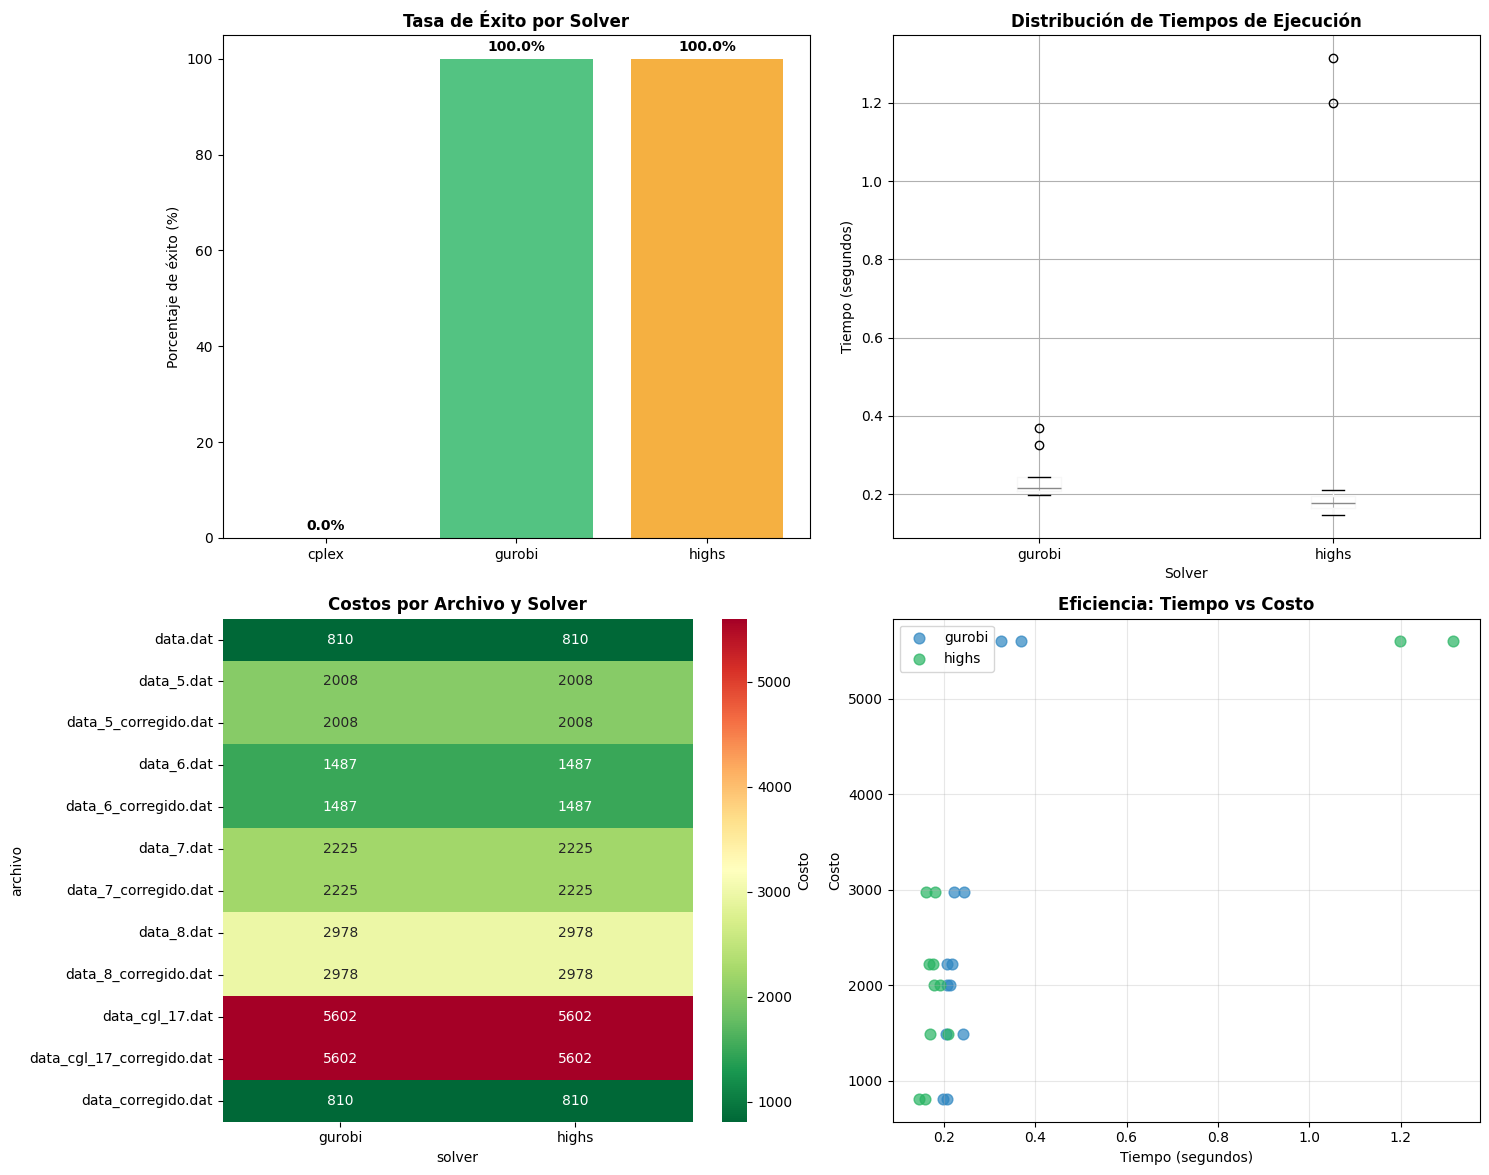


 Creando gráficos de soluciones individuales...
 Graficando mejor solución para data.dat (Solver: gurobi)


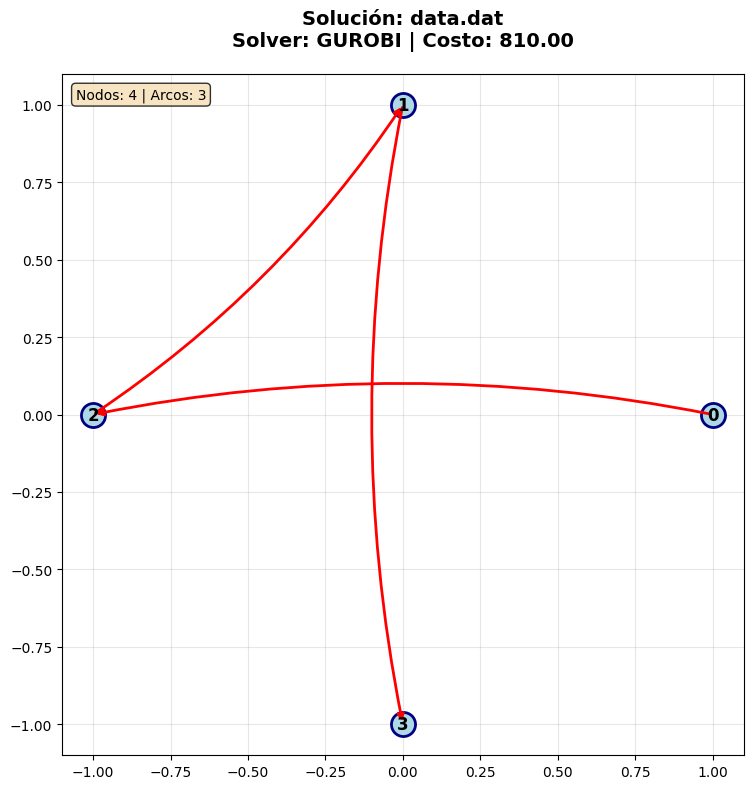

 Graficando mejor solución para data_5.dat (Solver: gurobi)


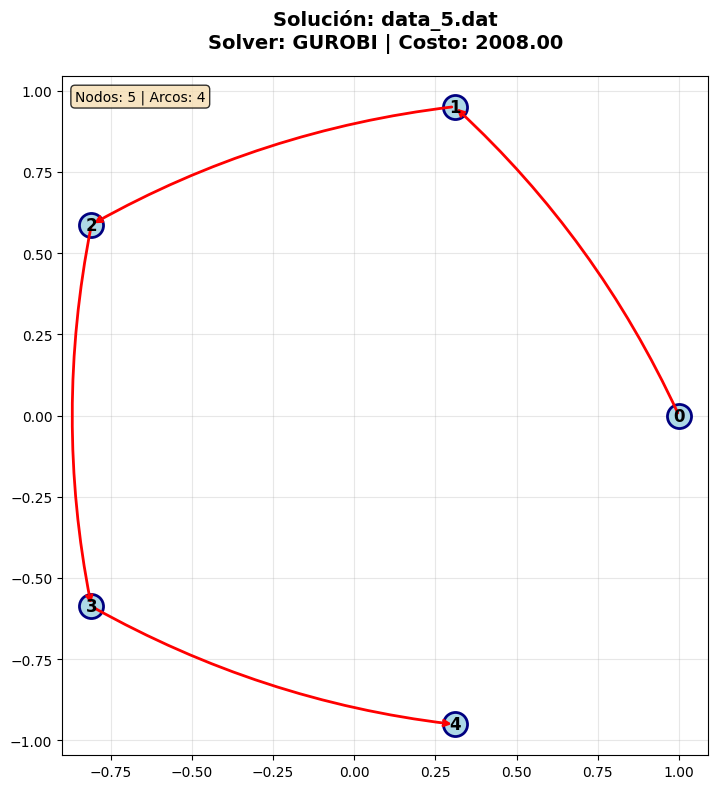

 Graficando mejor solución para data_5_corregido.dat (Solver: gurobi)


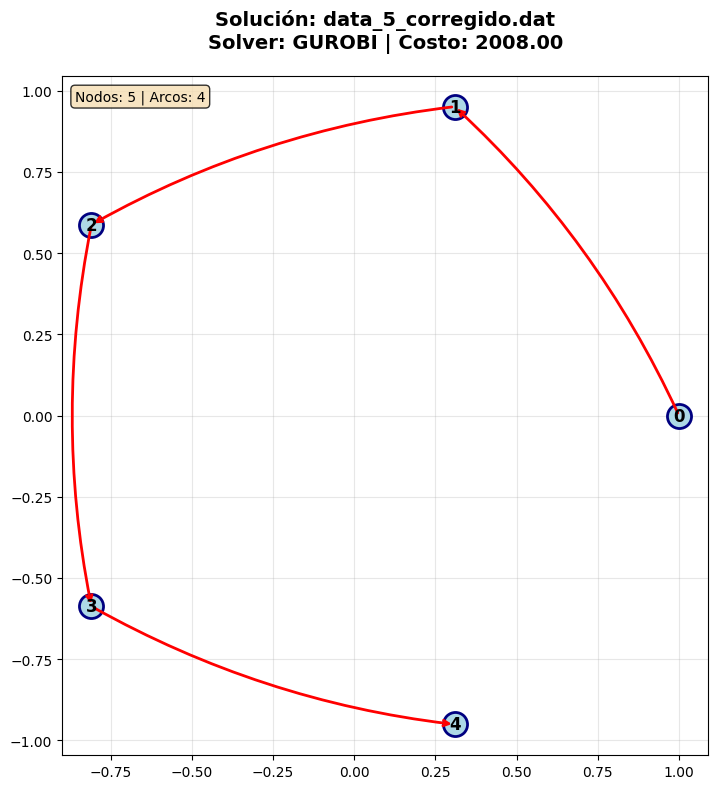


 ANÁLISIS DETALLADO:

 ANÁLISIS DETALLADO DE RESULTADOS

 Tasa de éxito por solver:
   CPLEX: 0.0% de éxito
   GUROBI: 100.0% de éxito
   HIGHS: 100.0% de éxito

 Tiempos de ejecución (solo soluciones exitosas):
          mean     min     max     std
solver                                
gurobi  0.2386  0.1991  0.3684  0.0532
highs   0.3547  0.1466  1.3151  0.4226

 Calidad de soluciones (costos):

   data.dat:
      1 gurobi: 810.00 (Gap: 0.00%)
      1 highs: 810.00 (Gap: 0.00%)

   data_5.dat:
      1 gurobi: 2008.00 (Gap: 0.00%)
      1 highs: 2008.00 (Gap: 0.00%)

   data_5_corregido.dat:
      1 gurobi: 2008.00 (Gap: 0.00%)
      1 highs: 2008.00 (Gap: 0.00%)

   data_6.dat:
      1 gurobi: 1487.00 (Gap: 0.00%)
      1 highs: 1487.00 (Gap: 0.00%)

   data_6_corregido.dat:
      1 gurobi: 1487.00 (Gap: 0.00%)
      1 highs: 1487.00 (Gap: 0.00%)

   data_7.dat:
      1 gurobi: 2225.00 (Gap: 0.00%)
      1 highs: 2225.00 (Gap: 0.00%)

   data_7_corregido.dat:
      1 gurobi: 2225.

In [9]:
print("Comparación completa con visualización")
print("=" * 50)

resultados_completos = comparar_solvers_con_graficos(
    solvers=['gurobi', 'highs', 'cplex'],
    time_limit=60,
    mostrar_graficos_analisis=True,
    mostrar_graficos_solucion=True
)

---

## ANÁLISIS Detallado


In [10]:
print("="*80)
print(" ANÁLISIS DE RESULTADOS DE LA COMPARACIÓN RÁPIDA")
print("="*80)

if 'resultados_rapidos' in locals() and resultados_rapidos is not None:
    print(f"\n INFORMACIÓN GENERAL:")
    print(f"   • Total de ejecuciones: {len(resultados_rapidos)}")
    print(f"   • Archivos procesados: {resultados_rapidos['archivo'].nunique()}")
    print(f"   • Solvers utilizados: {list(resultados_rapidos['solver'].unique())}")
    print(f"   • Límite de tiempo: 30 segundos por ejecución")
    
    print(f"\n RESULTADOS POR SOLVER:")
    for solver in resultados_rapidos['solver'].unique():
        datos_solver = resultados_rapidos[resultados_rapidos['solver'] == solver]
        exitosos = datos_solver[datos_solver['estado'].isin(['solved', 'optimal'])]
        tasa_exito = len(exitosos) / len(datos_solver) * 100
        
        print(f"\n   {solver.upper()}:")
        print(f"      • Instancias procesadas: {len(datos_solver)}")
        print(f"      • Soluciones encontradas: {len(exitosos)} ({tasa_exito:.1f}%)")
        
        if len(exitosos) > 0:
            print(f"      • Tiempo promedio: {exitosos['tiempo'].mean():.3f}s")
            print(f"      • Tiempo mínimo: {exitosos['tiempo'].min():.3f}s") 
            print(f"      • Tiempo máximo: {exitosos['tiempo'].max():.3f}s")
            print(f"      • Costo promedio: {exitosos['costo'].mean():.2f}")
            print(f"      • Mejor costo: {exitosos['costo'].min():.2f}")
    
    print(f"\n ANÁLISIS POR ARCHIVO:")
    for archivo in resultados_rapidos['archivo'].unique():
        datos_archivo = resultados_rapidos[resultados_rapidos['archivo'] == archivo]
        exitosos_archivo = datos_archivo[datos_archivo['estado'].isin(['solved', 'optimal'])]
        
        print(f"\n   {archivo}:")
        if len(exitosos_archivo) > 0:
            mejor_idx = exitosos_archivo['costo'].idxmin()
            mejor = exitosos_archivo.loc[mejor_idx]
            print(f"      Mejor resultado: {mejor['solver']} (Costo: {mejor['costo']:.2f}, Tiempo: {mejor['tiempo']:.3f}s)")
            
            print(f"      Todos los resultados:")
            for _, fila in datos_archivo.iterrows():
                if fila['estado'] in ['solved', 'optimal']:
                    simbolo = "1" if fila.name == mejor_idx else "check"
                    gap = ((fila['costo'] - mejor['costo']) / mejor['costo'] * 100) if mejor['costo'] > 0 else 0
                    print(f"         {simbolo} {fila['solver']}: {fila['costo']:.2f} ({fila['tiempo']:.3f}s) Gap: {gap:.1f}%")
                else:
                    print(f"        {fila['solver']}: {fila['estado']}")
        else:
            print(f"      Ningún solver encontró solución")
    
    archivos_corregidos = resultados_rapidos[resultados_rapidos['archivo_corregido'] == True]['archivo'].unique()
    if len(archivos_corregidos) > 0:
        print(f"\n🔧 ARCHIVOS QUE REQUIRIERON CORRECCIÓN:")
        for archivo in archivos_corregidos:
            print(f"   • {archivo} → Se creó {archivo.replace('.dat', '_corregido.dat')}")
        print(f"   Estos archivos tenían valores -1 en la diagonal de la matriz de costos")
    
else:
    print(" No se encontraron resultados de la comparación rápida")

print("\n" + "="*80)

 ANÁLISIS DE RESULTADOS DE LA COMPARACIÓN RÁPIDA

 INFORMACIÓN GENERAL:
   • Total de ejecuciones: 36
   • Archivos procesados: 12
   • Solvers utilizados: ['gurobi', 'highs', 'cplex']
   • Límite de tiempo: 30 segundos por ejecución

 RESULTADOS POR SOLVER:

   GUROBI:
      • Instancias procesadas: 12
      • Soluciones encontradas: 12 (100.0%)
      • Tiempo promedio: 0.272s
      • Tiempo mínimo: 0.226s
      • Tiempo máximo: 0.342s
      • Costo promedio: 2518.33
      • Mejor costo: 810.00

   HIGHS:
      • Instancias procesadas: 12
      • Soluciones encontradas: 12 (100.0%)
      • Tiempo promedio: 0.465s
      • Tiempo mínimo: 0.164s
      • Tiempo máximo: 1.417s
      • Costo promedio: 2518.33
      • Mejor costo: 810.00

   CPLEX:
      • Instancias procesadas: 12
      • Soluciones encontradas: 0 (0.0%)

 ANÁLISIS POR ARCHIVO:

   data.dat:
      Mejor resultado: gurobi (Costo: 810.00, Tiempo: 0.342s)
      Todos los resultados:
         1 gurobi: 810.00 (0.342s) Gap: 0.0%

In [11]:
print("\n" + "="*80)
print(" ANÁLISIS DE RESULTADOS DE LA COMPARACIÓN COMPLETA CON GRÁFICOS")
print("="*80)

if 'resultados_completos' in locals() and resultados_completos is not None:
    print(f"\n ESTADÍSTICAS AVANZADAS:")
    
    resumen_comparativo = []
    for solver in resultados_completos['solver'].unique():
        datos_solver = resultados_completos[resultados_completos['solver'] == solver]
        exitosos = datos_solver[datos_solver['estado'].isin(['solved', 'optimal'])]
        
        resumen_comparativo.append({
            'Solver': solver.upper(),
            'Instancias_Resueltas': f"{len(exitosos)}/{len(datos_solver)}",
            'Tasa_Éxito': f"{len(exitosos)/len(datos_solver)*100:.1f}%",
            'Tiempo_Promedio': f"{exitosos['tiempo'].mean():.3f}s" if len(exitosos) > 0 else "N/A",
            'Tiempo_Mediana': f"{exitosos['tiempo'].median():.3f}s" if len(exitosos) > 0 else "N/A",
            'Costo_Promedio': f"{exitosos['costo'].mean():.2f}" if len(exitosos) > 0 else "N/A",
            'Desv_Tiempo': f"{exitosos['tiempo'].std():.3f}s" if len(exitosos) > 1 else "N/A"
        })
    
    import pandas as pd
    df_resumen = pd.DataFrame(resumen_comparativo)
    print(f"\n TABLA COMPARATIVA COMPLETA:")
    print(df_resumen.to_string(index=False))
    
    print(f"\n ANÁLISIS DE COMPETITIVIDAD:")
    
    ganadores = {}
    for archivo in resultados_completos['archivo'].unique():
        datos_archivo = resultados_completos[resultados_completos['archivo'] == archivo]
        exitosos_archivo = datos_archivo[datos_archivo['estado'].isin(['solved', 'optimal'])]
        
        if len(exitosos_archivo) > 0:
            mejor_costo = exitosos_archivo.loc[exitosos_archivo['costo'].idxmin()]
            mejor_tiempo = exitosos_archivo.loc[exitosos_archivo['tiempo'].idxmin()]
            
            ganadores[archivo] = {
                'mejor_costo': mejor_costo['solver'],
                'mejor_tiempo': mejor_tiempo['solver'],
                'costo_optimo': mejor_costo['costo'],
                'tiempo_minimo': mejor_tiempo['tiempo']
            }
    
    victorias_costo = {}
    victorias_tiempo = {}
    
    for archivo, datos in ganadores.items():
        solver_costo = datos['mejor_costo']
        solver_tiempo = datos['mejor_tiempo']
        
        victorias_costo[solver_costo] = victorias_costo.get(solver_costo, 0) + 1
        victorias_tiempo[solver_tiempo] = victorias_tiempo.get(solver_tiempo, 0) + 1
    
    print(f"\n RANKING DE VICTORIAS:")
    print(f"    Por mejor costo (calidad):")
    for solver, wins in sorted(victorias_costo.items(), key=lambda x: x[1], reverse=True):
        print(f"      1 {solver.upper()}: {wins} victorias")
    
    print(f"\n   Por mejor tiempo (velocidad):")
    for solver, wins in sorted(victorias_tiempo.items(), key=lambda x: x[1], reverse=True):
        print(f"      1 {solver.upper()}: {wins} victorias")
    
    print(f"\n SOLVER MÁS EQUILIBRADO:")
    puntuacion_equilibrio = {}
    for solver in resultados_completos['solver'].unique():
        puntos_costo = victorias_costo.get(solver, 0)
        puntos_tiempo = victorias_tiempo.get(solver, 0)
        puntuacion_equilibrio[solver] = puntos_costo + puntos_tiempo
    
    mejor_equilibrio = max(puntuacion_equilibrio.items(), key=lambda x: x[1])
    print(f"   {mejor_equilibrio[0].upper()}: {mejor_equilibrio[1]} puntos totales")
    print(f"       (Combina {victorias_costo.get(mejor_equilibrio[0], 0)} victorias en costo + {victorias_tiempo.get(mejor_equilibrio[0], 0)} en tiempo)")

else:
    print(" No se encontraron resultados de la comparación completa")

print("\n" + "="*80)


 ANÁLISIS DE RESULTADOS DE LA COMPARACIÓN COMPLETA CON GRÁFICOS

 ESTADÍSTICAS AVANZADAS:

 TABLA COMPARATIVA COMPLETA:
Solver Instancias_Resueltas Tasa_Éxito Tiempo_Promedio Tiempo_Mediana Costo_Promedio Desv_Tiempo
GUROBI                12/12     100.0%          0.239s         0.216s        2518.33      0.053s
 HIGHS                12/12     100.0%          0.355s         0.178s        2518.33      0.423s
 CPLEX                 0/12       0.0%             N/A            N/A            N/A         N/A

 ANÁLISIS DE COMPETITIVIDAD:

 RANKING DE VICTORIAS:
    Por mejor costo (calidad):
      1 GUROBI: 12 victorias

   Por mejor tiempo (velocidad):
      1 HIGHS: 10 victorias
      1 GUROBI: 2 victorias

 SOLVER MÁS EQUILIBRADO:
   GUROBI: 14 puntos totales
       (Combina 12 victorias en costo + 2 en tiempo)

